In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
line = np.linspace(0, 100, 1000)

In [5]:
plt.plot(line, np.sin(line))

In [6]:
X = line.reshape(-1, 1)
y = np.sin(line) > 0

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X_train, y_train)

In [9]:
tree.score(X_train, y_train)

1.0

In [10]:
tree.score(X_test, y_test)

0.984

In [11]:
from scripts.transformer_prediction_interface import TabPFNClassifier
tabpfn = TabPFNClassifier(device="cpu", model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)

/anaconda/envs/tabpfn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
y_pred_tabpfn = tabpfn.fit(X_train, y_train).predict(X_test)

Using a Transformer with 25.83 M parameters
Using cpu device


In [13]:
tabpfn.fit(X_train, y_train).score(X_test, y_test)

0.508

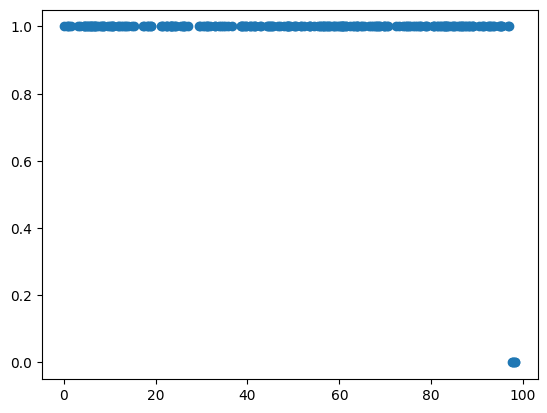

In [14]:
plt.plot(X_test.ravel(), y_pred_tabpfn, 'o')

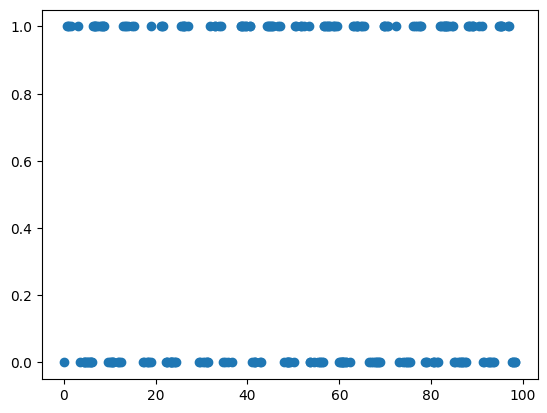

In [15]:
plt.plot(X_test.ravel(), tree.predict(X_test), 'o')

In [16]:
X_train.shape

(750, 1)

In [17]:
y_train.shape

(750,)

In [18]:
from tabpfn.transformer_make_model import ShiftClassifier, EnsembleMeta, ForwardMLPModel
device = "cpu"
mothernet_21_46_25_3940_ensemble3 = EnsembleMeta(ForwardMLPModel(path="mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)
y_pred_mothernet = mothernet_21_46_25_3940_ensemble3.fit(X_train, y_train).predict(X_test)

Using a Transformer with 149.66 M parameters
Using cpu device


In [19]:
mothernet_21_46_25_3940_ensemble3.score(X_test, y_test)

0.48

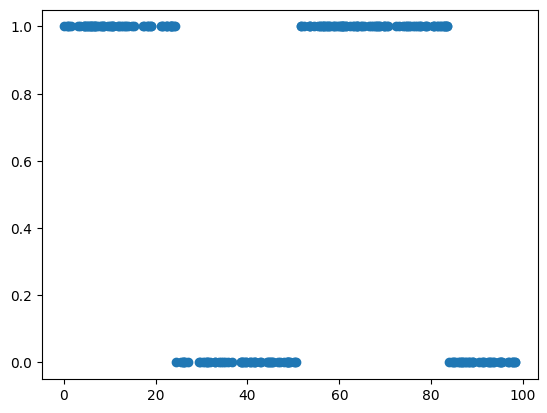

In [20]:
plt.plot(X_test.ravel(), y_pred_mothernet, 'o')

In [37]:
def make_data(n_classes, n_samples, n_steps):
    classes = (np.random.randint(0, n_classes) + np.cumsum(1 - 2 * np.random.randint(0, 2, size=n_steps))) % n_classes
    steps = np.sort(np.random.uniform(size=n_steps - 1))
    samples = np.random.uniform(size=n_samples)
    return samples.reshape(-1, 1), classes[np.searchsorted(steps, samples)]

In [22]:
n_steps = 10
n_samples = 100
n_classes = 3
classes = (np.random.randint(0, n_classes) + np.cumsum(1 - 2 * np.random.randint(0, 2, size=n_steps))) % n_classes
steps = np.sort(np.random.uniform(size=n_steps - 1))
samples = np.random.uniform(size=n_samples)

In [38]:
X, y = make_data(3, 100, 10)

In [51]:
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import torch
torch.set_num_threads(1)
device = "cpu"
mothernet = EnsembleMeta(ForwardMLPModel(path="mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)
rf_scores = []
tabpfn_scores = []
mothernet_scores = []
mlp_scores = []
n_steps = []
for n_step in [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    for i in range(5):
        X, y = make_data(2, 2000, n_step)
        n_steps.append(n_step)
        mlp_scores.append(np.mean(cross_validate(MLPClassifier(max_iter=1000), X, y, cv=ShuffleSplit(train_size=.5))['test_score']))
        tabpfn_scores.append(np.mean(cross_validate(tabpfn, X, y, cv=ShuffleSplit(train_size=.5))['test_score']))
        mothernet_scores.append(np.mean(cross_validate(mothernet, X, y, cv=ShuffleSplit(train_size=.5))['test_score']))
        rf_scores.append(np.mean(cross_validate(RandomForestClassifier(), X, y, cv=ShuffleSplit(train_size=.5))['test_score']))

/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

In [52]:
import pandas as pd
df4 = pd.DataFrame({'tabpfn': tabpfn_scores, 'rf': rf_scores, 'mothernet': mothernet_scores, 'mlp': mlp_scores, 'n_steps': n_steps})

<AxesSubplot:xlabel='n_steps', ylabel='value'>

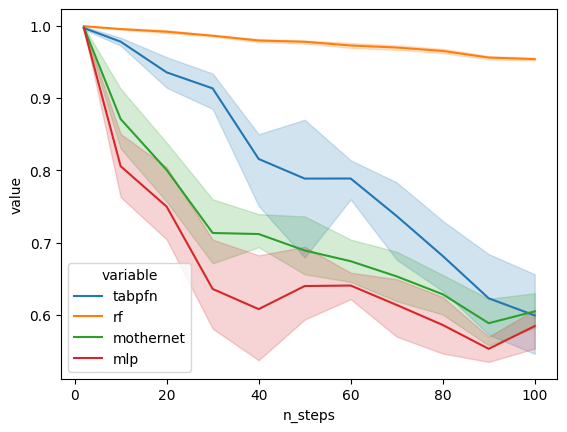

Bad pipe message: %s [b"9\xb9\xf3\x85\xc7\x9f\xcd\x18\xd0V\xf3\xbdIX\x0b\x17D\xcb\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00"]
Bad pipe message: %s [b'\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08']
Bad pipe message: %s [b'\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x02']
Bad pipe message: %s [b'\x05

In [53]:
sns.lineplot(data=df4.melt(id_vars="n_steps"), x="n_steps", y="value", hue="variable", )


In [30]:
import seaborn as sns

/anaconda/envs/tabpfn/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/anaconda/envs/tabpfn/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='n_steps', ylabel='value'>

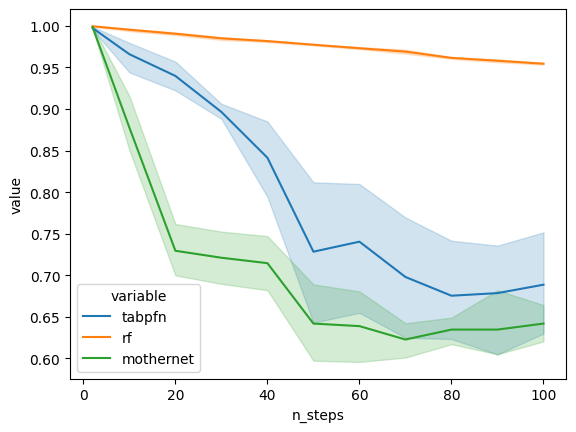

In [50]:
sns.lineplot(data=df3.melt(id_vars="n_steps"), x="n_steps", y="value", hue="variable", )


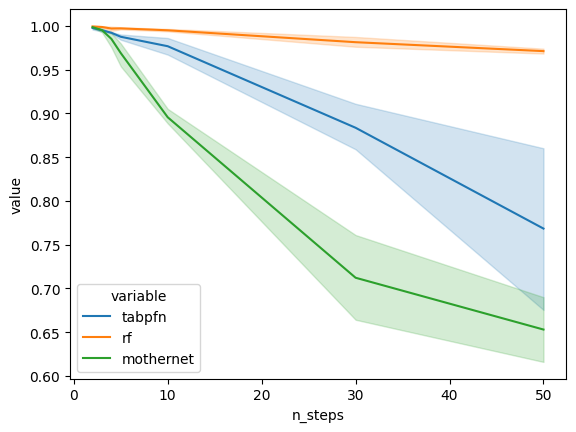

In [43]:
a = sns.lineplot(data=df2.melt(id_vars="n_steps"), x="n_steps", y="value", hue="variable", )
#a.set(xscale='log')

[None]

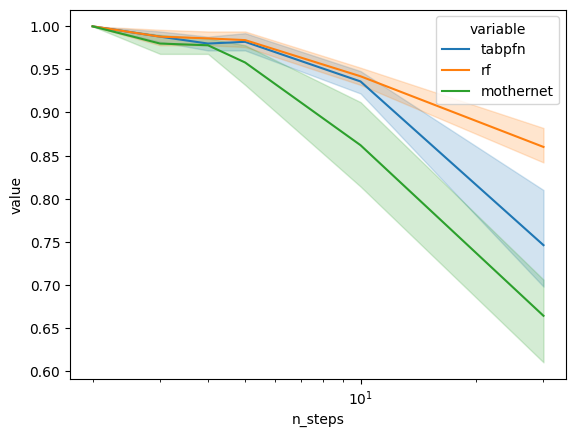

In [36]:
a = sns.lineplot(data=df.melt(id_vars="n_steps"), x="n_steps", y="value", hue="variable", )
a.set(xscale='log')

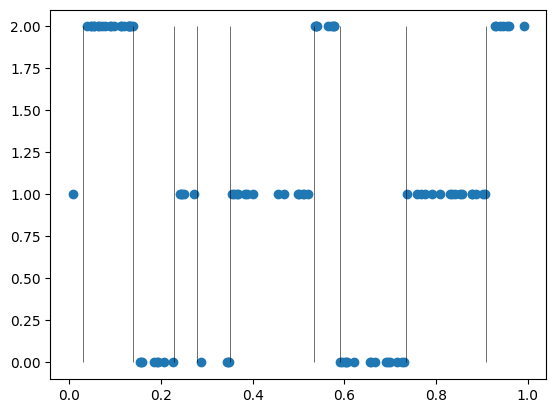

In [111]:
plt.plot(samples, y, 'o')
plt.vlines(steps, ymin=0, ymax=n_classes - 1, color='k', linewidth=.4)

In [ ]:
\